<a href="https://colab.research.google.com/github/simjeongho/XceptionV2/blob/gan/WGan_6464red.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
import functools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tqdm
import time
from IPython import display
from tensorflow import keras 
from tensorflow.keras.layers import *
from pathlib import Path

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
path = Path('/content/drive/MyDrive/red_64/')
len(os.listdir(path))

88

In [63]:
img_fn = [str(path/fn) for fn in os.listdir(path)]

In [64]:
dataset = tf.data.Dataset.from_tensor_slices(img_fn)
print(dataset)

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [65]:
import cv2
def preprocess(fn):
    img = tf.io.read_file(fn)
    img = tf.image.decode_jpeg(img, 3)
    img = tf.cast(img, dtype=tf.float32)
    #img = (img - 127.5) / 127.5
    img = img / 255
    img = tf.image.resize(img, (64, 64))
    return img

In [66]:
TOTAL=88
BATCH_SIZE=8

In [67]:
dataset = dataset.map(preprocess, num_parallel_calls=-1).cache()

In [68]:
dataset = dataset.shuffle(TOTAL).batch(BATCH_SIZE, drop_remainder=True)

In [69]:
dataset = dataset.prefetch(32)

In [70]:
plt.imshow(next(dataset.as_numpy_iterator())[3])

In [71]:
next(dataset.as_numpy_iterator())[:8].shape

(8, 64, 64, 3)

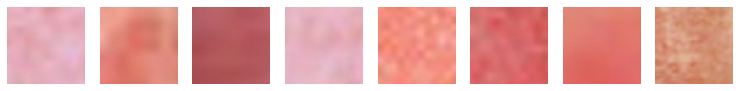

In [72]:
def show(images):
    fig, ax = plt.subplots(1, 8, figsize=(13, 13))
    for i, a in enumerate(ax):
        a.imshow(np.squeeze(images[i]))
        a.axis('off')
    plt.show()
show(next(dataset.as_numpy_iterator())[:8])

In [73]:
class WeightClipping(keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)

In [74]:
class ConvLayer(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv = Conv2D(nf, ks, strides=strides, padding=padding,
                           kernel_initializer='he_normal', kernel_constraint=constraint, use_bias=False)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = LeakyReLU(0.2)
        
    def call(self, X):
        X = self.act(self.conv(X))
        return self.norm(X)
    
def conv_layer(nf, ks, strides=2, padding='same'):
    conv = Conv2D(nf, ks, strides=strides, padding=padding, use_bias=False)
    bn = BatchNormalization()
    act = LeakyReLU(0.2)
    return keras.Sequential([conv, act, bn])

In [75]:
def critic(input_shape=(64, 64, 3), dim=64, n_downsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    # 1: downsamplings, ... -> 16x16 -> 8x8 -> 4x4
    h = ConvLayer(dim, 4, strides=2, padding='same')(h)
    for i in range(n_downsamplings - 1):
        d = min(dim * 2 ** (i + 1), dim * 8)
        h = ConvLayer(d, 4, strides=2, padding='same')(h)

    h = keras.layers.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer='he_normal')(h)
    h = Flatten()(h)
    return keras.Model(inputs=inputs, outputs=h)

In [76]:
d = critic()
d.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv_layer_12 (ConvLayer)   (None, 32, 32, 64)        3200      
                                                                 
 conv_layer_13 (ConvLayer)   (None, 16, 16, 128)       131328    
                                                                 
 conv_layer_14 (ConvLayer)   (None, 8, 8, 256)         524800    
                                                                 
 conv_layer_15 (ConvLayer)   (None, 4, 4, 512)         2098176   
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 1, 1)           8193      
                                                                 
 flatten_3 (Flatten)         (None, 1)                 0   

In [77]:
class UpsampleBlock(Layer):
    def __init__(self, nf, ks, strides=2, padding='same', constraint=None, **kwargs):
        super().__init__(**kwargs)
        self.conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding, 
                                              kernel_initializer='he_normal', kernel_constraint=constraint)
#         self.bn = BatchNormalization()
        self.norm = LayerNormalization()
        self.act = ReLU()
        
    def call(self, X):
        X = self.act(self.conv_transpose(X))
        return self.norm(X)
    
def deconv_layer( nf, ks, strides=2, padding='same'):
    conv_transpose = Conv2DTranspose(nf, ks, strides=strides, padding=padding)
    bn = BatchNormalization()
    act = ReLU()
    return keras.Sequential([conv_transpose, act, bn])

In [78]:
def generator(input_shape=(1, 1, 128), output_channels=3, dim=64, n_upsamplings=4):
    h = inputs = keras.Input(shape=input_shape)
    d = min(dim * 2 ** (n_upsamplings - 1), dim * 8)
    h = UpsampleBlock(d, 4, strides=1, padding='valid')(h)
    
    #  upsamplings, 4x4 -> 8x8 -> 16x16 -> ...
    for i in range(n_upsamplings - 1):
        d = min(dim * 2 ** (n_upsamplings - 2 - i), dim * 8)
        h = UpsampleBlock(d, 4, strides=2, padding='same')(h)
        
    h = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                     kernel_initializer='he_normal')(h)
    h = keras.layers.Activation('tanh')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [79]:
g = generator()
g.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 upsample_block_13 (Upsample  (None, 4, 4, 512)        1050112   
 Block)                                                          
                                                                 
 upsample_block_14 (Upsample  (None, 8, 8, 256)        2097920   
 Block)                                                          
                                                                 
 upsample_block_15 (Upsample  (None, 16, 16, 128)      524672    
 Block)                                                          
                                                                 
 upsample_block_16 (Upsample  (None, 32, 32, 64)       131264    
 Block)                                                    

In [80]:
#Wasserstein loss
def d_loss(real, fake):
    real_loss = -tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
#     real_lbl = tf.ones_like(real)
#     fake_lbl = tf.zeros_like(fake)
#     real_loss = tf.losses.binary_crossentropy(real_lbl, real)
#     fake_loss = tf.losses.binary_crossentropy(fake_lbl, fake)
    return real_loss + fake_loss

def g_loss(fake):
#     return tf.losses.binary_crossentropy(tf.ones_like(fake), fake)
    return - tf.reduce_mean(fake)

In [81]:
@tf.function
def gradient_penalty(model, real, fake):
    shape = [tf.shape(real)[0]] + [1, 1, 1]
    alpha = tf.random.uniform(shape=shape, minval=0, maxval=1)
    interpolated = alpha * real  + (1-alpha) * fake
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = model(interpolated)
    grad = tape.gradient(pred, interpolated)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [82]:
EPOCHS = 10
BATCH_SIZE = 4
noise_dim = 128

In [83]:
optD = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)
optG = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0, beta_2=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [84]:
@tf.function
def trainD(real):
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        fake_images = g(noise, training=True)
        real_output = d(real, training=True)
        fake_output = d(fake_images, training=True)
        gp_loss = gradient_penalty(functools.partial(d, training=True), real, fake_images)
        loss = d_loss(real_output, fake_output)
        disc_loss = loss + 10 * gp_loss
        
    d_grad = tape.gradient(disc_loss, d.trainable_variables)
    optD.apply_gradients(zip(d_grad, d.trainable_variables))
    
    
@tf.function
def trainG():
    noise = tf.random.normal((BATCH_SIZE, 1, 1, noise_dim))
    with tf.GradientTape() as tape:
        generated_images = g(noise, training=True)
        loss = g_loss(d(generated_images))
        
    g_grad = tape.gradient(loss, g.trainable_variables)
    optG.apply_gradients(zip(g_grad, g.trainable_variables))

In [85]:
seed = tf.random.normal((16, 1, 1, 128))

In [86]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig, ax = plt.subplots(4, 4, figsize=(10,10))

    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.show()

In [87]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm(dataset, total=88//BATCH_SIZE):
          # train_step(image_batch)
            trainD(image_batch)
            if optD.iterations.numpy() % 5 == 0:
                trainG()

        display.clear_output(wait=True)
        generate_images(g, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

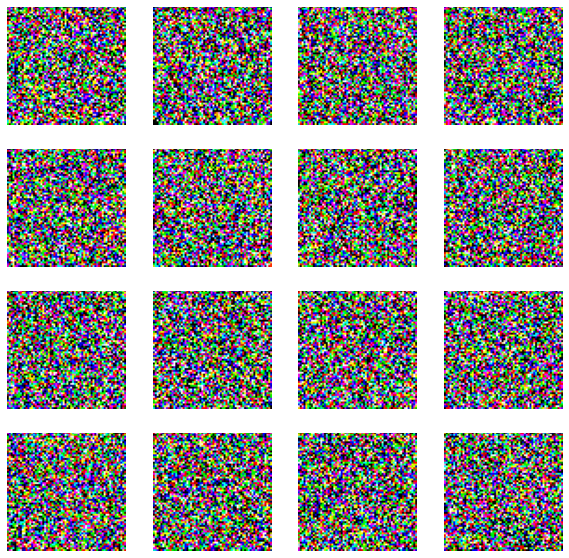

Time for epoch 1 is 18.326984643936157 sec


In [88]:
train(dataset, 1)
# 1 epochs

In [89]:
train(dataset, 100)

Time for epoch 100 is 0.9100565910339355 sec


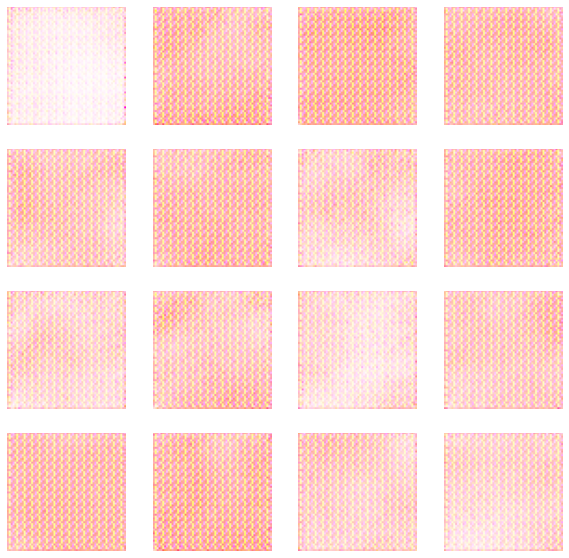

Time for epoch 500 is 0.8728518486022949 sec


In [90]:
train(dataset, 500)

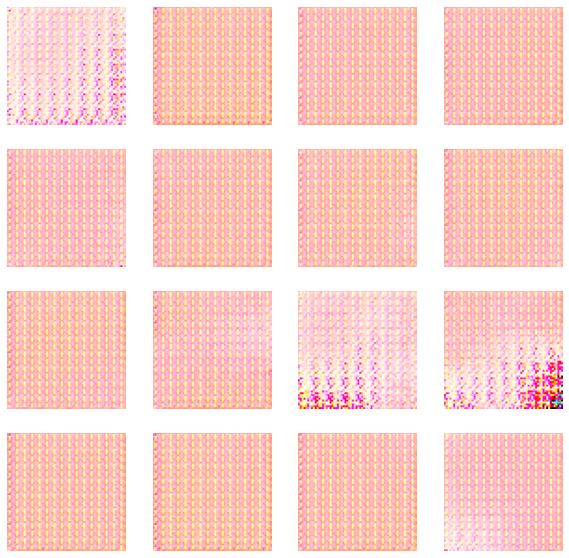

Time for epoch 1000 is 0.8859727382659912 sec


In [91]:
train(dataset, 1000)

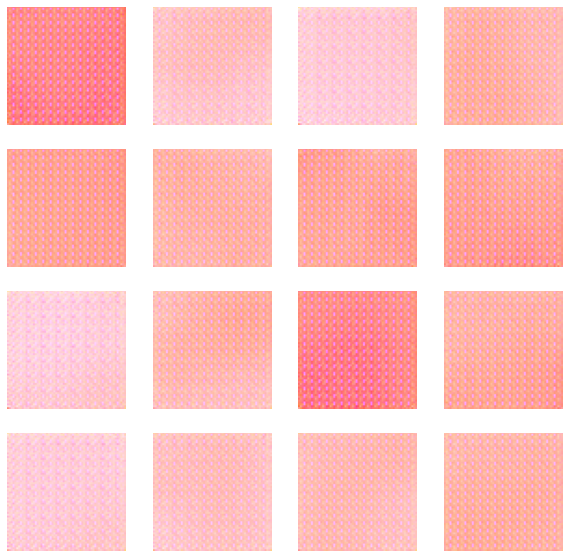

Time for epoch 1000 is 0.8468050956726074 sec


In [92]:
train(dataset, 1000)

In [93]:
# g.save('atopy_Generator1.h5')
# g.save_weights("atopy_Generator_Weight1")
# d.save('atopy_Discriminator.h5')
# d.save_weights("atopy_Discriminator_Weight")

NotImplementedError: ignored

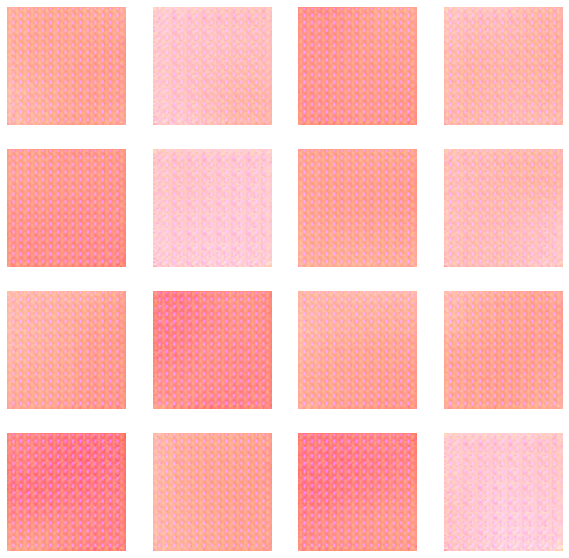

In [94]:
generate_images(g, 1, tf.random.normal([16, 1, 1, 128]))

In [95]:
train(dataset, 5000)

Time for epoch 5000 is 0.8361623287200928 sec


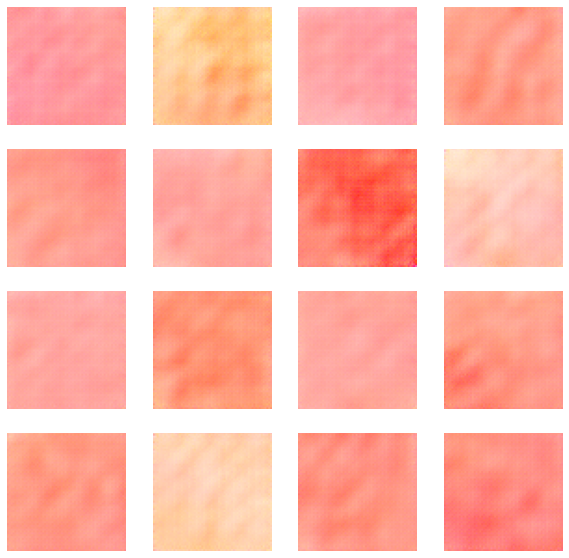

Time for epoch 5000 is 0.7689006328582764 sec


In [96]:
train(dataset, 5000)

In [ ]:
g.save('atopy_generator.h5')

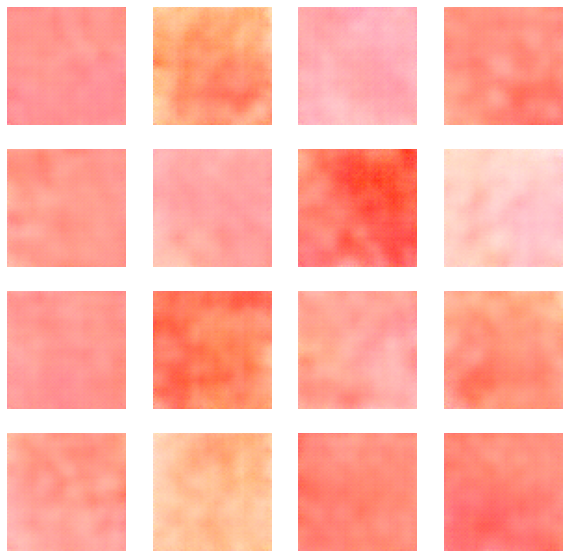

Time for epoch 5000 is 0.9916303157806396 sec


In [97]:
train(dataset, 5000)

In [98]:
train(dataset, 5000)

Time for epoch 5000 is 0.7437689304351807 sec


In [100]:
g.compile()

In [104]:

g.save_weights("atopy_Generator_Weight1")

d.save_weights("atopy_Discriminator_Weight")

In [108]:
!pwd


/content


In [110]:
g.save('/content/drive/MyDrive/atopyRedGenerator')


In [111]:
d.save('/content/drive/MyDrive/atopyRedDiscriminator')

In [112]:
generate_images(g, 1, tf.random.normal([16, 1, 1, 128])) # 학습된 모델로 생성한 이미지 

In [118]:
generate_images(g, 1, tf.random.normal([16, 1, 1, 128])) # 학습된 모델로 생성한 이미지 

In [166]:
import numpy as np
from tifffile import imsave
from PIL import Image

In [177]:
def generate_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
   # plt.imsave('generateRed.jpg', predictions[1,:,:,:])
    #print(predictions[1].shape)
    
    fig, ax = plt.subplots(4, 4, figsize=(10,10))
    for i, a in enumerate(ax.flat):
        a.imshow(predictions[i, :, :, :])
        a.axis('off')
    plt.show()

In [ ]:
# import numpy as np
# from tifffile import imsave

# predictions = model(test_input, training=False)

# for i, image in enumerate(pred, 1):
#     imsave(f'output_test/{i}.tif', image)

In [178]:
generate_save_images(g, 1, tf.random.normal([16, 1, 1, 128]))

(64, 64, 3)
